# **Install**

In [ ]:
!pip install progress

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9630 sha256=f3469d0f04e86ff5661d66fcf7d42d65c28db6718b0c52fbb3a9f269aacb27a3
  Stored in directory: /root/.cache/pip/wheels/4c/9b/0a/a78ff56725af3ef70792f9ed0f8dbbc4c0315edc62cbc4a6b8
Successfully built progress


# **Imports**

In [ ]:
import numpy as np
from scipy.special import logsumexp
import matplotlib.pyplot as plt
from progress.bar import IncrementalBar
import sys

# **Activation Functions**

In [ ]:
# derivative function, gets function output as input and computer derivative
class Linear:
    def __init__(self):
        self.__name__ = 'linear'

    def __call__(self, Z):
        return Z

    def derivative(self, Z, *args, **kwargs):
        return 1


class Relu:
    def __init__(self):
        self.__name__ = 'relu'

    def __call__(self, Z):
       
        return Z * (Z > 0)

    def derivative(self, Z, *args, **kwargs):
        return (Z > 0) * 1


class Sigmoid:
    def __init__(self):
        self.__name__ = 'sigmoid'

    def __call__(self, Z):
        return 1 / (1 + np.exp(-Z))

    def derivative(self, Z, *args, **kwargs):
        return Z * (1 - Z)



# stable version of softmax:
class Softmax:
    def __init__(self):
        self.__name__ = 'softmax'

    def __call__(self, Z):
        e = -np.max(Z, axis=1, keepdims=True)
        exp = np.exp(Z + e)
        return exp / np.sum(exp, axis=1, keepdims=True)

    def derivative(self, Z, *args, **kwargs):
        raise Exception('cannot get derivative')


class Tanh:
    def __init__(self):
        self.__name__ = 'tanh'

    def __call__(self, Z):
        return np.tanh(Z)

    def derivative(self, Z, *args, **kwargs):
        return 1 - (np.tanh(Z) ** 2)


sigmoid = Sigmoid
softmax = Softmax
relu = Relu
linear = Linear
tanh = Tanh

# Split Train/Test Data with Shuffle

In [ ]:
class Static_split:
    def __init__(self, test_split=0.2):
        self.test_split = test_split

    def set_data(self, X, y, shuffle=True):
        if shuffle == False:
            p = np.arange(X.shape[0])
        else:
            p = np.random.permutation(X.shape[0])

        split = int(X.shape[0] * self.test_split)
        self.X_test = X[p[:split]]
        self.y_test = y[p[:split]]
        self.X_train = X[p[split:]]
        self.y_train = y[p[split:]]

    def get_test_data(self):
        return self.X_test, self.y_test

    def get_train_data(self):
        return self.X_train, self.y_train


class kfold_split:
    def __init__(self, k=5):
        self.k = k

    def set_data(self, X, y, shuffle=True):
        if shuffle == False:
            p = np.arange(X.shape[0])
        else:
            p = np.random.permutation(X.shape[0])

        self.split = np.random.randint(0, self.k, size=X.shape[0])
        self.X = X
        self.y = y

    def __iter__(self):
        return self.__next__()

    def __next__(self):
        for i in range(self.k):
            yield self.X[self.split != i], self.y[self.split != i], self.X[self.split == i], self.y[self.split == i]

# **Layers**

In [ ]:
class Dense:
    def __init__(self, unit, activation=linear, input_dim=0, trainable=True):
        self.unit = unit
        self.__name__ = 'Dense'
        self.name = "dense"
        self.trainable = trainable
        if type(activation) == str:
            if activation.lower() == 'linear':
                activation = Linear()
            elif activation.lower() == 'sigmoid':
                activation = Sigmoid()
            elif activation.lower() == 'relu':
                activation = Relu()
            elif activation.lower() == 'softmax':
                activation = Softmax()
            elif activation.lower() == 'tanh':
                activation = Tanh()
            else:
                raise Exception("Activation function " + activation + " not found!")

        self.activation = activation
        self.input_dim = input_dim

    def set_name(self, name):
        self.name = name

    def compile(self, input_dim=-1):
        if input_dim == -1:
            assert self.input_dim != 0
        else:
            self.input_dim = input_dim

        self.W = (np.random.random(size=(self.input_dim + 1, self.unit))) - 0.5
        self.W = self.W / (self.W.std() * (input_dim + self.unit) ** 0.5)

    def __call__(self, X, activation=True):
        if activation:
            return self.activation(np.dot(np.hstack((X, np.ones((X.shape[0], 1)))), self.W))
        else:
            return np.dot(np.hstack((X, np.ones((X.shape[0], 1)))), self.W)

    def set_trainable(self, trainable):
        self.trainable = trainable

    #Update Weights
    def update(self, dw):
        if self.trainable:
            self.W = self.W + dw

    def reset_weights(self):
        self.W = (np.random.random(size=self.W.shape)) - 0.5
        self.W = self.W / (self.W.std() * (self.W.shape[0] + self.unit) ** 0.5)


# **Loss Functions**

In [ ]:
class Cross_entropy:
    def __init__(self, last_layer_activation):
        if last_layer_activation == 'sigmoid':
            self.get_loss = self.call_sigmoid
            self.derivative = self.derivative_sigmoid
        elif last_layer_activation == 'softmax':
            self.get_loss = self.call_softmax
            self.derivative = self.derivative_softmax

    def call_sigmoid(self, z, y):
        return np.mean(z * (1 - y) + np.logaddexp(0, -z))

    def derivative_sigmoid(self, h, y):
        return h - y

    def call_softmax(self, z, y):
        return -np.mean(np.sum(y * (z - logsumexp(z, axis=1, keepdims=True)), axis=1))

    def derivative_softmax(self, h, y):
        return h - y

    def get_loss(self, h, y):
        return -np.mean(np.sum(y * np.log(h) + (1 - y) * np.log(1 - h), axis=1))

    def derivative(self, h, y):
        return (h - y) / (h * (1 - h))

    def __call__(self, h, y):
        self.get_loss(h, y)

# **Model**

In [ ]:
class Sequential:
    def __init__(self):
        self.remove_last_layer_activation = False
        self.layers = []
        self.loss = None
        self.optimizer = None
        self.regularization = None
        self.layer_counter = 1

    def add(self, layer):
        layer.set_name('dense_' + str(self.layer_counter))
        self.layer_counter += 1
        self.layers.append(layer)

    def initialize_layers(self):
        input_dim = -1
        for layer in self.layers:
            layer.compile(input_dim)
            input_dim = layer.unit

    def compile(self, optimizer='SGD', loss='cross_entropy', regularization=None):
        if loss.lower() == 'cross_entropy':
            self.loss = Cross_entropy(self.layers[-1].activation.__name__)
            if self.layers[-1].activation.__name__ == "sigmoid" or self.layers[-1].activation.__name__ == "softmax":
                self.remove_last_layer_activation = True

        if type(optimizer) == str:
            if optimizer.lower() == 'sgd':
                optimizer = SGD()
            elif optimizer.lower() == 'momentum_sgd':
                optimizer = Momentum_SGD()
            elif optimizer.lower() == 'adagrad':
                optimizer = Adagrad()
            elif optimizer.lower() == 'rmsprop':
                optimizer = RMSprop()
            elif optimizer.lower() == 'adam':
                optimizer = Adam()
            else:
                raise Exception("Optimizer " + optimizer + " not found!")

        if regularization is not None and type(regularization) == str:
            if regularization.lower() == 'l1':
                regularization = L1()
            elif regularization.lower() == 'l2':
                regularization = L2()

        self.regularization = regularization
        self.optimizer = optimizer


        self.initialize_layers()

    def fit(self, X, y, batch_size=32, epoch=1, test_data=None):
        assert self.loss is not None

        history = {'acc': np.zeros(epoch), 'loss': np.zeros(epoch)}
        if test_data is not None:
            history['val_acc'] = np.zeros(epoch)
            history['val_loss'] = np.zeros(epoch)

        for epch in range(epoch):
            print('Epoch', epch + 1)
            sum_loss = 0
            sum_acc = 0
            bt_conter = 0

            required_batchs = int(X.shape[0] / batch_size + 0.99999999)
            bar = IncrementalBar(max=required_batchs,
                                 suffix='%(index)d/%(max)d - %(eta)ds')

            epoch_shufle = np.random.permutation(X.shape[0])

            for bt in range(0, X.shape[0], batch_size):
                bt_conter += 1
                # single batch:
                X_batch = X[epoch_shufle[bt:min(bt + batch_size, X.shape[0])]]
                y_batch = y[epoch_shufle[bt:min(bt + batch_size, X.shape[0])]]

                layer_output = [X_batch]
                for j, layer in enumerate(self.layers):
                    layer_output.append(layer(layer_output[-1]))

                delta_next = self.loss.derivative(layer_output[-1], y_batch)
                if not self.remove_last_layer_activation:
                    delta_next *= self.layers[-1].activation.derivative(layer_output[-1])

                grad = [0 for i in range(len(self.layers))]
                regularization_grad = [0 for i in range(len(self.layers))]
                if self.regularization is not None:
                    regularization_grad = self.regularization.derivative(self.layers)

                for i in range(len(self.layers) - 1, 0, -1):
                    delta_prev = np.dot(delta_next, self.layers[i].W.T[:, :-1]) * \
                                 self.layers[i - 1].activation.derivative(layer_output[i])

                    delta_wi = np.dot(np.hstack((layer_output[i], np.ones((layer_output[i].shape[0], 1)))).T,
                                      delta_next)
                    grad[i] = delta_wi / X_batch.shape[0] + regularization_grad[i]

                    delta_next = delta_prev

                delta_wi = np.dot(np.hstack((layer_output[0], np.ones((layer_output[0].shape[0], 1)))).T, delta_next)
                grad[0] = delta_wi / X_batch.shape[0] + regularization_grad[0]

                self.optimizer.update(grad, self.layers)

                d = self.evaluate(X_batch, y_batch)
                loss, acc = d['loss'], d['acc']
                sum_acc += acc
                sum_loss += loss
                bar.next()
              
#                 sys.stdout.write(" loss: %f acc: %f" % (sum_loss / (bt_conter + 1), sum_acc / (bt_conter + 1)))
#                 sys.stdout.flush()

            bar.finish()
            d = self.evaluate(X, y)
            loss, acc = d['loss'], d['acc']
            if test_data is not None:
                d = self.evaluate(test_data[0], test_data[1])
                val_loss, val_acc = d['loss'], d['acc']
                history['val_loss'][epch] = val_loss
                history['val_acc'][epch] = val_acc
                history['loss'][epch] = loss
                history['acc'][epch] = acc
                print('loss: {} acc: {} val_loss: {} val_acc: {}'.format(loss, acc, val_loss, val_acc))
            else:
                history['loss'][epch] = loss
                history['acc'][epch] = acc
                print('loss: {} acc: {}'.format(loss, acc))

        return history

    def predict(self, X, batch_size=32, last_activation=True):
        return np.argmax(self.predict_proba(X, batch_size=batch_size, last_activation=last_activation), axis=1)

    def predict_proba(self, X, batch_size=32, last_activation=True):
        output = np.zeros((X.shape[0], self.layers[-1].unit))

        for i in range(0, X.shape[0], batch_size):
            t = X[i:min(i + batch_size, X.shape[0])].copy()
            for j, layer in enumerate(self.layers):
                t = layer(t, activation=(j != len(self.layers) - 1 or last_activation))

            output[i:min(i + batch_size, X.shape[0])] = t

        return output

    def evaluate(self, X, y, batch_size=32):
        if self.loss is not None:
            p = self.predict_proba(X, batch_size=batch_size, last_activation=not self.remove_last_layer_activation)
            loss = self.loss.get_loss(p, y)
            if self.regularization is not None:
                loss += self.regularization.cost(self.layers)

            if self.remove_last_layer_activation:
                p = self.layers[-1].activation(p)

            pred = np.argmax(p, axis=1)
            y_class = np.argmax(y, axis=1)

            acc = np.sum(pred == y_class) / p.shape[0]
            return {'loss': loss, 'acc': acc}
        else:
            p = self.predict_proba(X, batch_size=batch_size)

            pred = np.argmax(p, axis=1)
            y_class = np.argmax(y, axis=1)

            acc = np.sum(pred == y_class) / p.shape[0]
            return {'acc': acc}

    def summary(self):
        print("_" * 65)
        print('Layer (type)                 Output Shape              Param #')
        print("=" * 65)

        layer_type = 'Input'
        output_shape = '(None, {})'.format(str(self.layers[0].input_dim))
        params = '0'
        print('{:<29}'.format(layer_type) +
              '{:<26}'.format(output_shape) +
              '{}'.format(params))
        print("-" * 65)

        trainable_params = 0
        non_trainable_params = 0

        for l in self.layers:
            layer_type = l.name + ' ({})'.format(l.__name__)
            output_shape = '(None, {})'.format(str(l.unit))
            params = '{}'.format(l.W.shape[0] * l.W.shape[1])

            if l.trainable:
                trainable_params += l.W.shape[0] * l.W.shape[1]
            else:
                non_trainable_params += l.W.shape[0] * l.W.shape[1]

            print('{:<29}'.format(layer_type) +
                  '{:<26}'.format(output_shape) +
                  '{}'.format(params))
            print("-" * 65)

        print('Total params:', trainable_params + non_trainable_params)
        print('Trainable params:', trainable_params)
        print('Non-trainable params:', non_trainable_params)
        print("_" * 65)
        print('Optimizer : {}'.format(self.optimizer.__name__))
        if self.regularization is not None:
            print('Regularization : {}'.format(self.regularization.__name__))
        print("-" * 65)
        print()
        print()

    def save_weights(self, path):
        import os
        try:
            os.rmdir(path)
        except:
            pass

        os.mkdir(path)

        for i, layer in enumerate(self.layers):
            np.save(os.path.join(path, str(i) + '.npy'), layer.W)

    def load_weights(self, path):
        import os
        assert len(os.listdir(path)) == len(self.layers)

        for i, layer in enumerate(self.layers):
            self.layers[i].W = np.load(os.path.join(path, str(i) + '.npy'))

    def reset_weights(self):
        for layer in self.layers:
            layer.reset_weights()


# === Regularization ===

## **L1 Regularization**

In [ ]:
class L1:
    def __init__(self, lam=0.001):
        self.lam = lam
        self.__name__ = 'L1 Regularization'

    def cost(self, layers):
        # L1 Regularization Cost function 
        # input: layers -> list of layers. you can access the weight matrix of i'th layer
        #                  using "layers[i].W".
        #                  layers[i].W[-1, :] is the bias term and layers[i].W[:-1, :]
        #                  will give you all weights
        #
        # output: one float number. this number is the total cost of the Regularization term.
        #         don't forget to effect "self.lam" in the return value. lam is the
        #         Regularization Coefficient.

        cost = 0
        
        for l in layers:
            cost += np.sum(np.abs(l.W[:-1, :]))
            
        return cost * self.lam


    def derivative(self, layers):
        # L1 Regularization Cost function Derivatives
        # input: layers -> list of layers. you can access weight matrix of i'th layer
        #                  using "layers[i].W".
        #                  layers[i].W[-1, :] is the bias term and layers[i].W[:-1, :]
        #                  will give you all weights
        #
        # output: a list of matrices. output[i] is a matrix with same shapes of layers[i].W
        #         matrix and indicates derivative of each weight respect to the Regularization term
        


        # initialize dw with the same shape as l.W.shape with bias

        dw = [np.zeros(l.W.shape) * self.lam for l in layers]
        
        for i in range(len(layers)):
            dw[i][:-1, :] = np.sign(layers[i].W[:-1, :]) * self.lam

        return dw

## **L2 Regularization**


In [ ]:
class L2:
    def __init__(self, lam=0.001):
        self.lam = lam
        self.__name__ = 'L2 Regularization'

    def cost(self, layers):

        # L2 Regularization Cost function
        # input: layers -> list of layers. you can access the weight matrix of i'th layer
        #                  using "layers[i].W".
        #                  layers[i].W[-1, :] is the bias term and layers[i].W[:-1, :]
        #                  will give you all weights
        #
        # output: one float number. this number is the total cost of the Regularization term.
        #         don't forget to effect "self.lam" in the return value. lam is the
        #         Regularization Coefficient.

        cost = 0
        
        for l in layers:
            cost += np.sum(np.square(l.W[:-1, :]))
            
        return cost * self.lam


    def derivative(self, layers):

        # input: layers -> list of layers. you can access weight matrix of i'th layer
        #                  using "layers[i].W".
        #                  layers[i].W[-1, :] is the bias term and layers[i].W[:-1, :]
        #                  will give you all weights
        #
        # output: a list of matrices. output[i] is a matrix with same shapes of layers[i].W
        #         matrix and indicates derivative of each weight respect to the Regularization term
        #

        # initialize dw with the same shape as l.W.shape with bias row

        dw = [np.zeros(l.W.shape) * self.lam for l in layers]

        for i in range(len(layers)):
            dw[i][:-1, :] = 2 * (layers[i].W[:-1, :]) * self.lam

        return dw


# Load Dataset

In [ ]:
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

In [ ]:
fashion_mnist.load_data?

In [ ]:
# load data, normalize and split into train, validation and test sets.

def load_dataset():

    # load the fashion_mnist from keras.datasets
    # split train/test
    
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    ## Normalizing data with Z-score normalization, mean=>0, std=>1

    train_mean = x_train.mean()
    train_std = x_train.std()
    
    x_train = (x_train - train_mean) / train_std
    x_test = (x_test - train_mean) / train_std

    # one-hot encoding of y
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    # flatten Xs:
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)

    ## split validation data 

    split_data = Static_split(test_split=0.2)
    split_data.set_data(x_train, y_train)
    (X_train_new, y_train_new) = split_data.get_train_data()
    (X_val, y_val) = split_data.get_test_data()

    
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
    return X_train_new, y_train_new, x_test, y_test, X_val, y_val


# === Optimizers ===

## **SGD**

In [ ]:
# SGD Optimizer as a template to see how you can write Optimizers.
# Calling layer.update(delta) method, will simply update weight matrix
# by formula:
# w_new = w_old + delta
# All classes have a dummy output to prevent errors. the output is just SGD update rule

class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.__name__ = 'SGD'

    def update(self, grads, layers):
        for layer, delta in zip(layers, grads):
            layer.update(-delta * self.lr)

sgd = SGD

### **Test SGD**

Testing 3 different models with different number of neurons in hidden layer,  you can test this part here or later in next blocks.



# Test SGD - 20 Neurons in hidden layer

(60000, 784) (60000, 10) (10000, 784) (10000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 20)                15700
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                210
-----------------------------------------------------------------
Total params: 15910
Trainable params: 15910
Non-trainable params: 0
_________________________________________________________________
Optimizer : SGD
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 1.5390353830769985 acc: 0.7319166666666667 val_loss: 1.5534451161935223 val_acc: 0.7295833333333334
Epoch 2
loss: 1.4342915925299784 acc: 0.7605625 val_loss: 1.4549616952652098 va

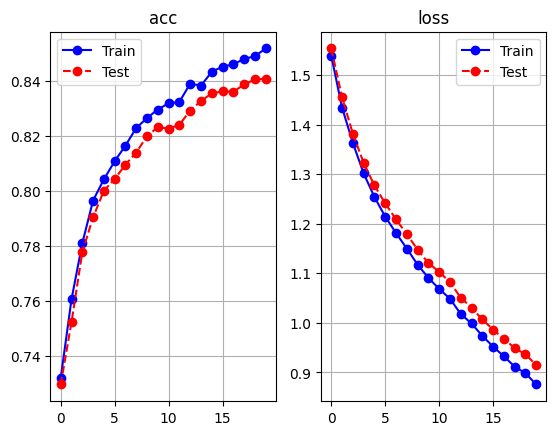

In [ ]:
X_train_new, y_train_new, X_test, y_test, X_val, y_val = load_dataset()

model = Sequential()
model.add(Dense(20, 'relu', input_dim=X_train_new.shape[1])) # hidden layer, 20 neurons with relu activation function
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function

model.compile(loss='cross_entropy', optimizer='sgd', regularization='l2')

model.summary()

history = model.fit(X_train_new, y_train_new, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))

plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.show()

# Test SGD - 75 Neurons in hidden layer

(60000, 784) (60000, 10) (10000, 784) (10000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 75)                58875
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                760
-----------------------------------------------------------------
Total params: 59635
Trainable params: 59635
Non-trainable params: 0
_________________________________________________________________
Optimizer : SGD
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 1.3550255805510862 acc: 0.7930625 val_loss: 1.351534669458888 val_acc: 0.7928333333333333
Epoch 2
loss: 1.2668636995778975 acc: 0.8180833333333334 val_loss: 1.2635529542884498 val

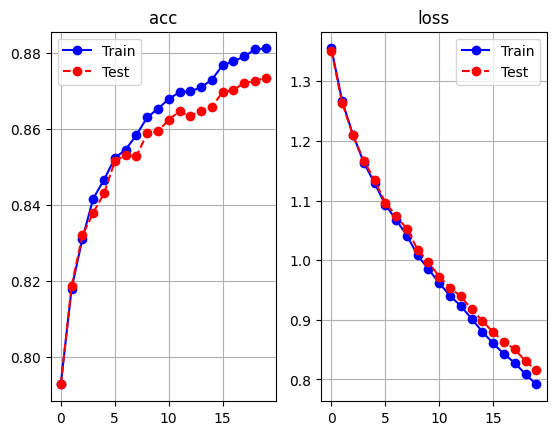

In [ ]:
X_train_new, y_train_new, X_test, y_test, X_val, y_val = load_dataset()

model = Sequential()
model.add(Dense(75, 'relu', input_dim=X_train_new.shape[1])) # hidden layer, 75 neurons with relu activation function
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function

model.compile(loss='cross_entropy', optimizer='sgd', regularization='l2')

model.summary()

history = model.fit(X_train_new, y_train_new, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))

plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.show()

# Test SGD - 150 Neurons in hidden layer

(60000, 784) (60000, 10) (10000, 784) (10000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 150)               117750
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                1510
-----------------------------------------------------------------
Total params: 119260
Trainable params: 119260
Non-trainable params: 0
_________________________________________________________________
Optimizer : SGD
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 1.301763197312455 acc: 0.8136666666666666 val_loss: 1.3114243559190273 val_acc: 0.8111666666666667
Epoch 2
loss: 1.2193057285937974 acc: 0.8367291666666666 val_loss: 1.2316933

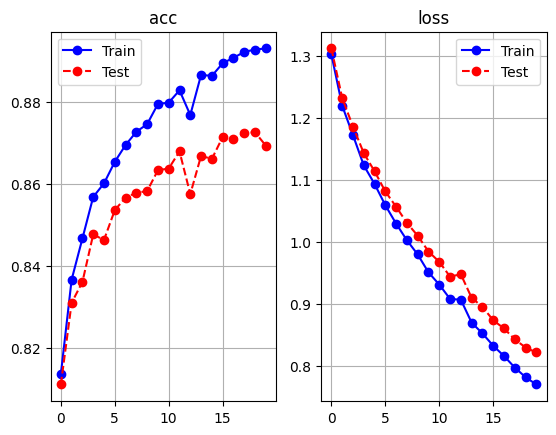

In [ ]:
X_train_new, y_train_new, X_test, y_test, X_val, y_val = load_dataset()

model = Sequential()
model.add(Dense(150, 'relu', input_dim=X_train_new.shape[1])) # hidden layer, 150 neurons with relu activation function
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function

model.compile(loss='cross_entropy', optimizer='sgd', regularization='l2')

model.summary()

history = model.fit(X_train_new, y_train_new, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))

plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.show()

## **Momentum SGD**


In [ ]:
class Momentum_SGD(SGD):
    def __init__(self, lr=0.01, momentum=0.9):
        super().__init__(lr)
        self.momentum = momentum

        # Helping attribute
        self.velocity = None

        self.__name__ = 'Momentum_SGD'
    

    # eq 8.21 from page 300
    def update_velocity(self, grads):
        if self.velocity is None:
            self.velocity = [0 for i in range(len(grads))]

        for i in range(len(grads)):
            self.velocity[i] = self.momentum * self.velocity[i] - self.lr * grads[i]

    
    def update(self, grads, layers):
        # inputs are grads and layers.
        #        grads is a list of gradient matrices.
        #        layers is a list of layers.

        self.update_velocity(grads)
        
        for layer, v in zip(layers, self.velocity):
            layer.update(v)

momentum_sgd = Momentum_SGD

**### Test Momentum SGD**



(60000, 784) (60000, 10) (10000, 784) (10000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 75)                58875
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                760
-----------------------------------------------------------------
Total params: 59635
Trainable params: 59635
Non-trainable params: 0
_________________________________________________________________
Optimizer : Momentum_SGD
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 1.0162359711997817 acc: 0.8542916666666667 val_loss: 1.0409646509590393 val_acc: 0.8533333333333334
Epoch 2
loss: 0.8302757010651678 acc: 0.8688541666666667 val_loss: 0.8

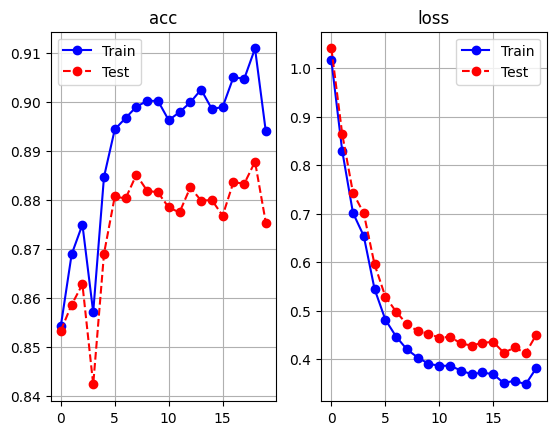

In [ ]:
X_train_new, y_train_new, X_test, y_test, X_val, y_val = load_dataset()

model = Sequential()
model.add(Dense(75, 'relu', input_dim=X_train_new.shape[1])) # hidden layer, 75 neurons with relu activation function
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function

model.compile(loss='cross_entropy', optimizer='momentum_sgd', regularization='l2')

model.summary()

history = model.fit(X_train_new, y_train_new, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))

plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.show()

## **Adagrad**


In [ ]:
class Adagrad:
    def __init__(self, lr=0.01):
        self.global_lr = lr
        self.epsilon = 1e-7
        self.velocity = None
        self.accumulated_gradient = None

        self.__name__ = 'AdaGrad'
            
    def update(self, grads, layers):
        # inputs are grads and layers.
        #        grads is a list of gradient matrices.
        #        layers is a list of layers.
        
        if self.velocity is None:
            self.velocity = [0 for i in range(len(grads))]
            self.accumulated_gradient = [0 for i in range(len(grads))]

        for i in range(len(grads)):
            self.accumulated_gradient[i] = self.accumulated_gradient[i] + (grads[i] ** 2)
            lr = self.global_lr / (self.epsilon + self.accumulated_gradient[i] ** 0.5)

            self.velocity[i] = - lr * grads[i]
            
        for layer, v in zip(layers, self.velocity):
            layer.update(v)

adagrad = Adagrad

**### Test Adagrad**



(60000, 784) (60000, 10) (10000, 784) (10000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 75)                58875
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                760
-----------------------------------------------------------------
Total params: 59635
Trainable params: 59635
Non-trainable params: 0
_________________________________________________________________
Optimizer : AdaGrad
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 0.9101973532629872 acc: 0.8504166666666667 val_loss: 0.9275351363400188 val_acc: 0.84375
Epoch 2
loss: 0.7713710993584426 acc: 0.8653541666666666 val_loss: 0.7911785788159895 

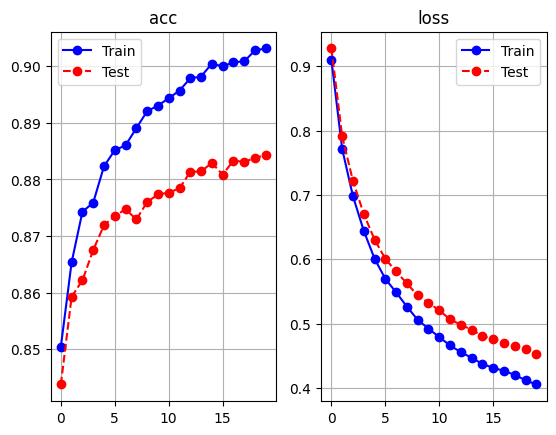

In [ ]:
X_train_new, y_train_new, X_test, y_test, X_val, y_val = load_dataset()

model = Sequential()
model.add(Dense(75, 'relu', input_dim=X_train_new.shape[1])) # hidden layer, 75 neurons with relu activation function
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function

model.compile(loss='cross_entropy', optimizer='adagrad', regularization='l2')

model.summary()

history = model.fit(X_train_new, y_train_new, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))

plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.show()

## **RMSprop**


In [ ]:
class RMSprop:
    def __init__(self, lr=0.001, rho=0.9):
        self.global_lr = lr
        self.rho = rho
        self.epsilon = 1e-7

        # Helping attribute
        self.velocity = None
        self.accumulated_gradient = None

        self.__name__ = 'RMSprop'
    
    def update(self, grads, layers):
        # inputs are grads and layers.
        #        grads is a list of gradient matrices.
        #        layers is a list of layers.
        
        if self.velocity is None:
            self.velocity = [0 for i in range(len(grads))]
            self.accumulated_gradient = [0 for i in range(len(grads))]

        for i in range(len(grads)):
            self.accumulated_gradient[i] = self.rho * self.accumulated_gradient[i] +\
                                           (1 - self.rho) * (grads[i] ** 2)
            lr = self.global_lr / (self.epsilon + self.accumulated_gradient[i]) ** 0.5

            self.velocity[i] = -lr * grads[i]

        for layer, v in zip(layers, self.velocity):
            layer.update(v)

rmsprop = RMSprop

**### Test RMSprop**



(60000, 784) (60000, 10) (10000, 784) (10000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 75)                58875
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                760
-----------------------------------------------------------------
Total params: 59635
Trainable params: 59635
Non-trainable params: 0
_________________________________________________________________
Optimizer : RMSprop
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 0.7824642674479276 acc: 0.8618125 val_loss: 0.7945737012815695 val_acc: 0.85925
Epoch 2
loss: 0.5709738223268067 acc: 0.8731458333333333 val_loss: 0.5932544407865781 val_acc: 

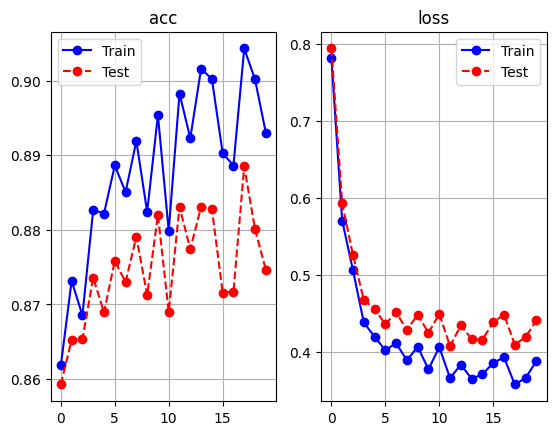

In [ ]:
X_train_new, y_train_new, X_test, y_test, X_val, y_val = load_dataset()

model = Sequential()
model.add(Dense(75, 'relu', input_dim=X_train_new.shape[1])) # hidden layer, 75 neurons with relu activation function
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function

model.compile(loss='cross_entropy', optimizer='rmsprop', regularization='l2')

model.summary()

history = model.fit(X_train_new, y_train_new, epoch=30,
                    batch_size=64, test_data=(X_val, y_val))

plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.show()

## **Adam**



In [ ]:
class Adam(Adagrad):
    def __init__(self, lr=0.001, rho_1=0.9, rho_2=0.999):
        self.global_lr = lr
        self.rho_1 = rho_1
        self.rho_2 = rho_2

        # Helping attribute
        self.first_moment_estimate = None
        self.second_moment_estimate = None
        self.t = 0
        self.__name__ = 'Adam'

            
    def update(self, grads, layers):
        # inputs are grads and layers.
        #        grads is a list of gradient matrices.
        #        layers is a list of layers.

        if self.first_moment_estimate is None:
            self.first_moment_estimate = [0 for i in range(len(grads))]
            self.second_moment_estimate = [0 for i in range(len(grads))]
            self.t = 0

        self.t += 1
            
        for i in range(len(layers)):
            self.first_moment_estimate[i] = self.rho_1 * self.first_moment_estimate[i] +\
                                           (1 - self.rho_1) * grads[i]
            s = self.first_moment_estimate[i] / (1 - self.rho_1 ** self.t)

            self.second_moment_estimate[i] = self.rho_2 * self.second_moment_estimate[i] +\
                                           (1 - self.rho_2) * (grads[i] ** 2)
            r = self.second_moment_estimate[i] / (1 - self.rho_2 ** self.t)

            deltaw = -self.global_lr * s / (1e-8 + r ** 0.5)
            
            layers[i].update(deltaw)

adam = Adam

**### Test Adam**



(60000, 784) (60000, 10) (10000, 784) (10000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 75)                58875
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                760
-----------------------------------------------------------------
Total params: 59635
Trainable params: 59635
Non-trainable params: 0
_________________________________________________________________
Optimizer : Adam
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 0.8474818312045377 acc: 0.8577291666666667 val_loss: 0.8641309768201137 val_acc: 0.855
Epoch 2
loss: 0.617301060269986 acc: 0.8686666666666667 val_loss: 0.6434594658661652 val_ac

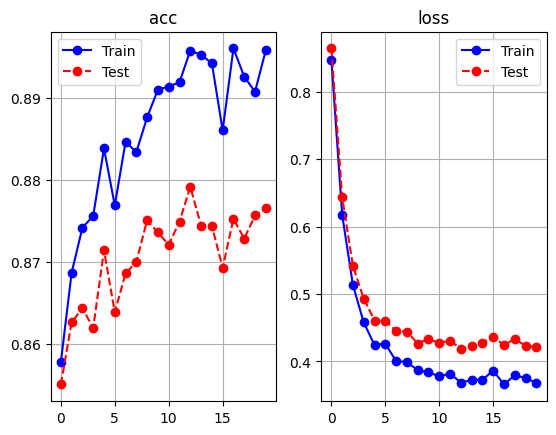

In [ ]:
X_train_new, y_train_new, X_test, y_test, X_val, y_val = load_dataset()

model = Sequential()
model.add(Dense(75, 'relu', input_dim=X_train_new.shape[1])) # hidden layer, 75 neurons with relu activation function
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function

model.compile(loss='cross_entropy', optimizer='adam', regularization='l2')

model.summary()

history = model.fit(X_train_new, y_train_new, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))

plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.show()


**Test Best Optimizer with another regularization**

Best Optimizer: Adagard //
Regularization: L1

(60000, 784) (60000, 10) (10000, 784) (10000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 75)                58875
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                760
-----------------------------------------------------------------
Total params: 59635
Trainable params: 59635
Non-trainable params: 0
_________________________________________________________________
Optimizer : AdaGrad
Regularization : L1 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 2.0197028671273696 acc: 0.8387916666666667 val_loss: 2.0355340560661217 val_acc: 0.8304166666666667
Epoch 2
loss: 1.1888106394186906 acc: 0.8506041666666667 val_loss: 1.203283

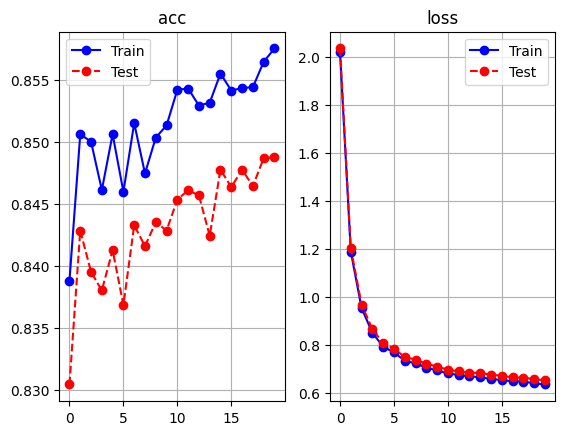

In [ ]:
X_train_new, y_train_new, X_test, y_test, X_val, y_val = load_dataset()

model = Sequential()
model.add(Dense(75, 'relu', input_dim=X_train_new.shape[1])) # hidden layer, 75 neurons with relu activation function
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function

model.compile(loss='cross_entropy', optimizer='adagrad', regularization='l1')

model.summary()

history = model.fit(X_train_new, y_train_new, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))

plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.show()

# Test best model on test data

using best model and run that on test dataset, report final accuracy

(60000, 784) (60000, 10) (10000, 784) (10000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 75)                58875
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                760
-----------------------------------------------------------------
Total params: 59635
Trainable params: 59635
Non-trainable params: 0
_________________________________________________________________
Optimizer : AdaGrad
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 0.9053747217078922 acc: 0.8556666666666667 val_loss: 0.9124401860613912 val_acc: 0.8526666666666667
Epoch 2
loss: 0.7756441936465643 acc: 0.8646875 val_loss: 0.788905902412198

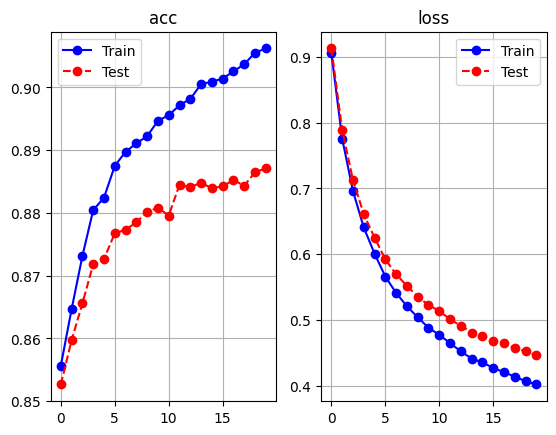

In [ ]:
X_train_new, y_train_new, X_test, y_test, X_val, y_val = load_dataset()

model = Sequential()
model.add(Dense(75, 'relu', input_dim=X_train_new.shape[1])) # hidden layer, 75 neurons with relu activation function
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function

# TODO: set best optimizer and regularization
model.compile(loss='cross_entropy', optimizer='adagrad', regularization='l2')

model.summary()

history = model.fit(X_train_new, y_train_new, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))

plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.show()

In [ ]:
print(model.evaluate(X_test, y_test))

{'loss': 0.4789199760283094, 'acc': 0.8763}


# Extra Step!
Neural Network with 2 hidden layer with 75 neurons in each layer

(60000, 784) (60000, 10) (10000, 784) (10000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 75)                58875
-----------------------------------------------------------------
dense_2 (Dense)              (None, 150)               11400
-----------------------------------------------------------------
dense_3 (Dense)              (None, 10)                1510
-----------------------------------------------------------------
Total params: 71785
Trainable params: 71785
Non-trainable params: 0
_________________________________________________________________
Optimizer : AdaGrad
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 0.8005954093612713 acc: 0.8615208333333333 val_

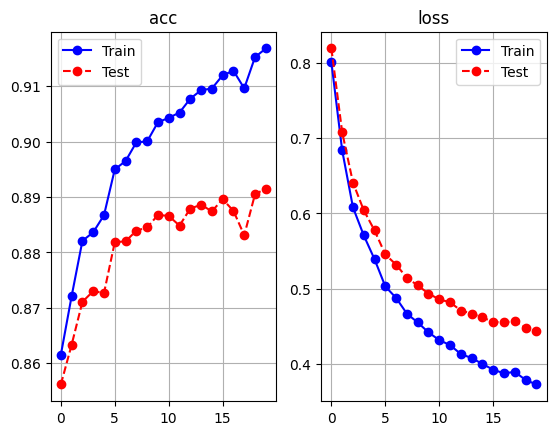

In [ ]:
X_train_new, y_train_new, X_test, y_test, X_val, y_val = load_dataset()

model = Sequential()
model.add(Dense(75, 'relu', input_dim=X_train_new.shape[1])) # hidden layer, 75 neurons with relu activation function
model.add(Dense(150, 'relu', input_dim=X_train_new.shape[1])) # hidden layer, 75 neurons with relu activation function
model.add(Dense(10, 'softmax')) # output layer, 10 neurons with softmax activation function

# TODO: set best optimizer and regularization
model.compile(loss='cross_entropy', optimizer='adagrad', regularization='l2')

model.summary()

history = model.fit(X_train_new, y_train_new, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))

plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Test')
plt.grid()
plt.legend()

plt.show()

In [ ]:
print(model.evaluate(X_test, y_test))

{'loss': 0.46613253396013776, 'acc': 0.8817}
